In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/ML Project/data_reduced.zip'

Streaming output truncated to the last 5000 lines.
  inflating: data_reduced/train_data/n000332/0320_01.jpg  
  inflating: data_reduced/train_data/n000332/0329_01.jpg  
  inflating: data_reduced/train_data/n000332/0330_01.jpg  
  inflating: data_reduced/train_data/n000332/0343_02.jpg  
  inflating: data_reduced/train_data/n000332/0346_01.jpg  
  inflating: data_reduced/train_data/n000332/0357_01.jpg  
  inflating: data_reduced/train_data/n000332/0388_01.jpg  
  inflating: data_reduced/train_data/n000332/0393_01.jpg  
  inflating: data_reduced/train_data/n000332/0404_01.jpg  
  inflating: data_reduced/train_data/n000332/0407_01.jpg  
  inflating: data_reduced/train_data/n000332/0408_01.jpg  
  inflating: data_reduced/train_data/n000332/0414_01.jpg  
  inflating: data_reduced/train_data/n000332/0421_01.jpg  
  inflating: data_reduced/train_data/n000332/0423_01.jpg  
  inflating: data_reduced/train_data/n000332/0425_01.jpg  
  inflating: data_reduced/train_data/n000332/0428_01.jpg  
  inf

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import shutil
import os 

# define function to plot results

def plot_history(history, yrange):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy per epoch
    plt.subplot(1,2,1)
    plt.plot(epochs, acc,  label='Train')
    plt.plot(epochs, val_acc , label='Val')
    
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(yrange)
    plt.legend(['Train', 'Val'], loc='lower right')
    
    # Plot training and validation loss per epoch
    #plt.figure()
    plt.subplot(1,2,2)
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    
    plt.title('Classification Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    
    #plt.show()
    plt.tight_layout()

In [5]:
from tensorflow.keras.applications import MobileNet

img_rows, img_cols = 224, 224 

mobilenet = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in mobilenet.layers:
    layer.trainable = False

In [ ]:
# print layers 
for (i,layer) in enumerate(mobilenet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 ReLU False
10 ZeroPadding2D False
11 DepthwiseConv2D False
12 BatchNormalization False
13 ReLU False
14 Conv2D False
15 BatchNormalization False
16 ReLU False
17 DepthwiseConv2D False
18 BatchNormalization False
19 ReLU False
20 Conv2D False
21 BatchNormalization False
22 ReLU False
23 ZeroPadding2D False
24 DepthwiseConv2D False
25 BatchNormalization False
26 ReLU False
27 Conv2D False
28 BatchNormalization False
29 ReLU False
30 DepthwiseConv2D False
31 BatchNormalization False
32 ReLU False
33 Conv2D False
34 BatchNormalization False
35 ReLU False
36 ZeroPadding2D False
37 DepthwiseConv2D False
38 BatchNormalization False
39 ReLU False
40 Conv2D False
41 BatchNormalization False
42 ReLU False
43 DepthwiseConv2D False
44 BatchNormalization False
45 ReLU False
46 Conv2D False
47 BatchNormalization False
48

In [ ]:
def Fc(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    #top_model = Flatten()(top_model)

    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(256,activation='relu')(top_model)

    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

# Set the class number to 1000 for the dataset
num_classes = 200

FC_Head = Fc(mobilenet, num_classes)

model = Model(inputs = mobilenet.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/data_reduced/train_data/'
validation_data_dir = '/content/data_reduced/val_data/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        horizontal_flip=True
        )
 
validation_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
 
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 16095 images belonging to 200 classes.
Found 400 images belonging to 200 classes.


In [ ]:
# unfreeze layers and train
for layer in mobilenet.layers:
    layer.trainable = True

In [ ]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import math

checkpoint = ModelCheckpoint("/content/drive/MyDrive/ML Project/best_weights/mobilenet_weights.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
#callbacks = [lrate, earlystop, checkpoint]
callbacks = [earlystop, checkpoint]
# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(learning_rate = 0.001),
              metrics = ['accuracy', 'AUC'])

In [ ]:
# Enter the number of training and validation samples here
nb_train_samples = 16095
nb_validation_samples = 400
# We only train 5 EPOCHS 
initial_epochs = 5

batch_size = 32

history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = initial_epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
    )

Epoch 1/5
502/502 [==============================] - ETA: 0s - loss: 4.4107 - accuracy: 0.0632 - auc: 0.7909
Epoch 00001: val_loss improved from inf to 4.32988, saving model to /content/drive/MyDrive/ML Project/models/mobilenet_checkpoint.h5
502/502 [==============================] - 2672s 5s/step - loss: 4.4107 - accuracy: 0.0632 - auc: 0.7909 - val_loss: 4.3299 - val_accuracy: 0.0469 - val_auc: 0.8230
Epoch 2/5
502/502 [==============================] - ETA: 0s - loss: 3.3966 - accuracy: 0.1853 - auc: 0.9073
Epoch 00002: val_loss improved from 4.32988 to 3.58940, saving model to /content/drive/MyDrive/ML Project/models/mobilenet_checkpoint.h5
502/502 [==============================] - 2686s 5s/step - loss: 3.3966 - accuracy: 0.1853 - auc: 0.9073 - val_loss: 3.5894 - val_accuracy: 0.1719 - val_auc: 0.8786
Epoch 3/5
502/502 [==============================] - ETA: 0s - loss: 2.8852 - accuracy: 0.2799 - auc: 0.9318
Epoch 00003: val_loss did not improve from 3.58940
502/502 [=============

In [ ]:
model.save_weights('/content/drive/MyDrive/ML Project/best_weights/mobilenet_weights.h5')

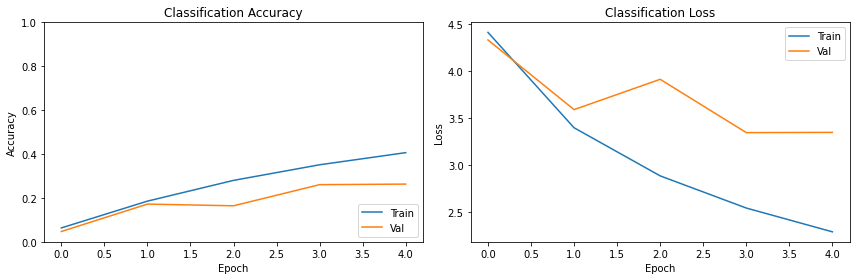

In [ ]:
# plot the model's result

mobilenet_train_acc_cat = history.history['accuracy']
mobilenet_val_acc_cat = history.history['val_accuracy']

plot_history(history, yrange=(0,1))

In [8]:
# load saved model for prediction
from keras.models import load_model

# load model
model = load_model('/content/drive/MyDrive/ML Project/best_weights/mobilenet_checkpoint.h5')

In [25]:
target = [
        'n000003',
        'n000010',
        'n000011',
        'n000013',
        'n000015',
        'n000017',
        'n000018',
        'n000020',
        'n000023',
        'n000024',
        'n000025',
        'n000028',
        'n000032',
        'n000033',
        'n000034',
        'n000035',
        'n000038',
        'n000041',
        'n000042',
        'n000046',
        'n000048',
        'n000049',
        'n000051',
        'n000053',
        'n000054',
        'n000057',
        'n000059',
        'n000062',
        'n000064',
        'n000065',
        'n000070',
        'n000072',
        'n000074',
        'n000075',
        'n000077',
        'n000086',
        'n000088',
        'n000089',
        'n000093',
        'n000101',
        'n000108',
        'n000110',
        'n000111',
        'n000113',
        'n000115',
        'n000118',
        'n000119',
        'n000120',
        'n000121',
        'n000125',
        'n000127',
        'n000130',
        'n000131',
        'n000143',
        'n000150',
        'n000151',
        'n000154',
        'n000155',
        'n000157',
        'n000158',
        'n000159',
        'n000163',
        'n000167',
        'n000168',
        'n000170',
        'n000171',
        'n000182',
        'n000185',
        'n000187',
        'n000188',
        'n000189',
        'n000192',
        'n000193',
        'n000195',
        'n000196',
        'n000197',
        'n000199',
        'n000202',
        'n000203',
        'n000204',
        'n000207',
        'n000208',
        'n000210',
        'n000211',
        'n000212',
        'n000214',
        'n000216',
        'n000217',
        'n000218',
        'n000219',
        'n000221',
        'n000224',
        'n000229',
        'n000231',
        'n000234',
        'n000236',
        'n000239',
        'n000240',
        'n000243',
        'n000248',
        'n000249',
        'n000250',
        'n000252',
        'n000253',
        'n000254',
        'n000256',
        'n000258',
        'n000261',
        'n000265',
        'n000267',
        'n000274',
        'n000276',
        'n000279',
        'n000281',
        'n000283',
        'n000285',
        'n000286',
        'n000287',
        'n000289',
        'n000290',
        'n000291',
        'n000295',
        'n000297',
        'n000298',
        'n000300',
        'n000303',
        'n000304',
        'n000306',
        'n000308',
        'n000309',
        'n000310',
        'n000311',
        'n000318',
        'n000323',
        'n000324',
        'n000327',
        'n000329',
        'n000332',
        'n000333',
        'n000334',
        'n000335',
        'n000336',
        'n000339',
        'n000340',
        'n000345',
        'n000347',
        'n000349',
        'n000351',
        'n000352',
        'n000354',
        'n000355',
        'n000357',
        'n000358',
        'n000359',
        'n000360',
        'n000361',
        'n000364',
        'n000365',
        'n000367',
        'n000369',
        'n000371',
        'n000375',
        'n000376',
        'n000379',
        'n000380',
        'n000383',
        'n000386',
        'n000387',
        'n000390',
        'n000391',
        'n000392',
        'n000397',
        'n000402',
        'n000403',
        'n000413',
        'n000415',
        'n000417',
        'n000418',
        'n000419',
        'n000420',
        'n000422',
        'n000423',
        'n000424',
        'n000427',
        'n000429',
        'n000434',
        'n000435',
        'n000437',
        'n000441',
        'n000442',
        'n000443',
        'n000444',
        'n000446',
        'n000449',
        'n000450',
        'n000451',
        'n000455',
        'n000457',
        'n000458',
        'n000461']

13/13 [==============================] - 12s 896ms/step
ROC AUC score:  0.6268844221105528


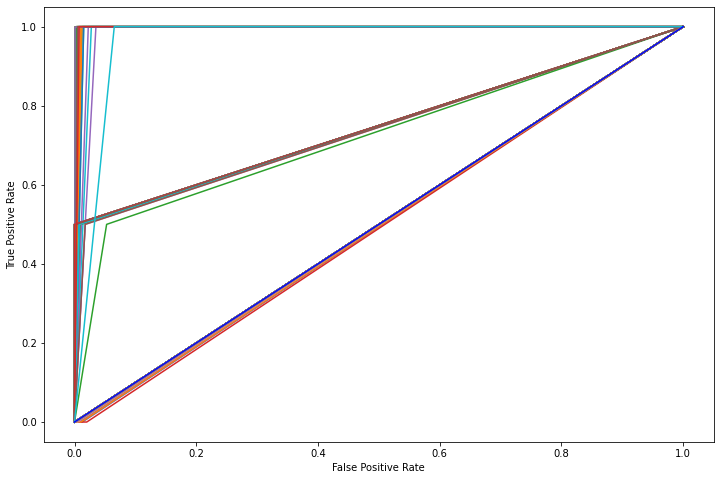

In [31]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt 
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target): # all_labels: no. of the labels
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
validation_generator.reset() # resetting generator
y_pred = model.predict(validation_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)


c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
print('ROC AUC score: ', multiclass_roc_auc_score(validation_generator.classes, y_pred))

# Finetune and retrain model

In [ ]:
mobilenet.trainable = True

# show how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenet.layers))

Number of layers in the base model:  86


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/content/drive/MyDrive/ML Project/best_weights/mobilenet_weights.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
#callbacks = [lrate, earlystop, checkpoint]
callbacks = [earlystop, checkpoint]
# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(learning_rate = (0.001/10)),
              metrics = ['accuracy', 'AUC'])

In [ ]:
# retrain for 5 more epochs
finetune_epochs = 15

total_epochs = initial_epochs + finetune_epochs

history_tuned = model.fit( 
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = total_epochs,
    initial_epoch =  history.epoch[-1],
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
    )

Epoch 5/20
502/502 [==============================] - ETA: 0s - loss: 1.8228 - accuracy: 0.5153 - auc: 0.9676
Epoch 00005: val_loss improved from inf to 2.44274, saving model to /content/drive/MyDrive/ML Project/best_weights/mobilenet_weights.h5
502/502 [==============================] - 731s 1s/step - loss: 1.8228 - accuracy: 0.5153 - auc: 0.9676 - val_loss: 2.4427 - val_accuracy: 0.4219 - val_auc: 0.9318
Epoch 6/20
502/502 [==============================] - ETA: 0s - loss: 1.7096 - accuracy: 0.5455 - auc: 0.9706
Epoch 00006: val_loss improved from 2.44274 to 2.43551, saving model to /content/drive/MyDrive/ML Project/best_weights/mobilenet_weights.h5
502/502 [==============================] - 728s 1s/step - loss: 1.7096 - accuracy: 0.5455 - auc: 0.9706 - val_loss: 2.4355 - val_accuracy: 0.4375 - val_auc: 0.9277
Epoch 7/20
502/502 [==============================] - ETA: 0s - loss: 1.6479 - accuracy: 0.5584 - auc: 0.9721
Epoch 00007: val_loss improved from 2.43551 to 2.35149, saving mod

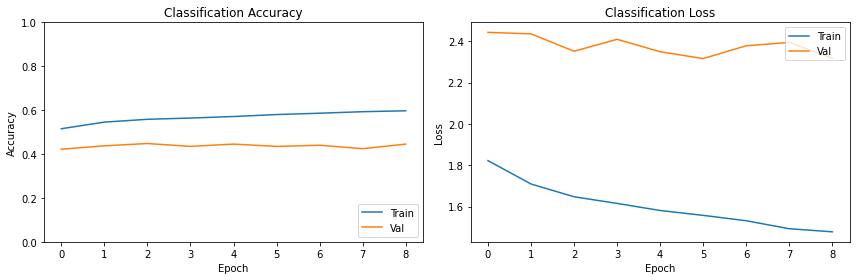

In [ ]:
# plot the model's result

mobilenet_tuned_train_acc_cat = history_tuned.history['accuracy']
mobilenet_tuned_val_acc_cat = history_tuned.history['val_accuracy']

plot_history(history_tuned, yrange=(0,1))

In [32]:
# load model
model = load_model('/content/drive/MyDrive/ML Project/best_weights/mobilenet_weights.h5')

13/13 [==============================] - 12s 897ms/step
ROC AUC score:  0.7160804020100503


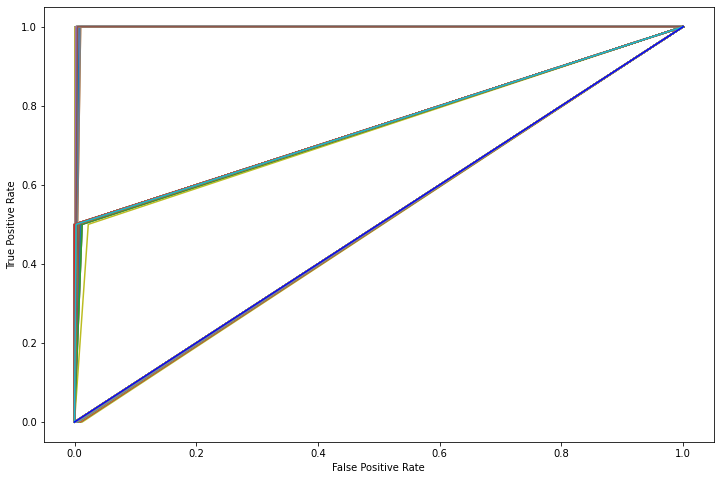

In [33]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt 
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# calling
validation_generator.reset() # resetting generator
y_pred = model.predict(validation_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)


c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
print('ROC AUC score: ', multiclass_roc_auc_score(validation_generator.classes, y_pred))

# Test the model

In [ ]:
# define function for testing the models

from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
import random

def model_tester(full_model):
    
    %matplotlib inline

    # This first part selects a random file from the validation directory
    type = random.choice(os.listdir('/content/data_reduced/test_data'))
    #print(type)
    file = random.choice(os.listdir(f'/content/data_reduced/test_data/{type}'))
    #print(file)

    random_path = '/content/data_reduced/test_data' + '/' + type + '/' + file
    #print(random_path)

    # We then create the list of labels 
    person_dict = train_generator.class_indices
    label_list = {v: k.lower().capitalize() for k, v in person_dict.items()}
    label_list

    # We then select the image, preprocess and predict the values from full_model
    img_path = random_path
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    answer=full_model.predict(x)
    probability=round(np.max(full_model.predict(x)*100),2)
    
    # Prediction
    print ('This model suggests the image below is a: ',
           label_list[np.argmax(full_model.predict(x)*100)],
           ' with a probability of' ,probability,'%' ) 
    
    plt.imshow(img) 
   
    # Ground Truth
    print('____________________________________')
    print('The ground truth is:  ' ,type)
    print('____________________________________\n')


    #If we want to display the next two likely outcomes we can use:
    z = full_model.predict(x)*100
    temp = np.argpartition(z[0], -3)[-3:]
    #print(temp)
    #print(z[0][temp])
    temp = np.argsort(-z[0])[:3]

    print('The two next most likely choices are: \n', 
            '          ' , label_list[temp[1]], 'with probability', round(z[0][temp][1], 2),'% \n', 
            '          ' , label_list[temp[2]], 'with probability', round(z[0][temp][2], 2), '%' )
    print('____________________________________')

This model suggests the image below is a:  N000304  with a probability of 95.09 %
____________________________________
The ground truth is:   n000304
____________________________________

The two next most likely choices are: 
            N000369 with probability 2.65 % 
            N000212 with probability 1.0 %
____________________________________


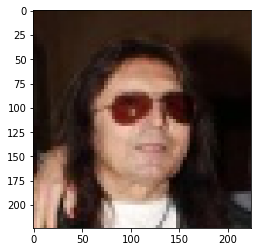

In [ ]:
model_tester(full_model=model)

This model suggests the image below is a:  N000239  with a probability of 47.71 %
____________________________________
The ground truth is:   n000239
____________________________________

The two next most likely choices are: 
            N000248 with probability 12.13 % 
            N000285 with probability 7.72 %
____________________________________


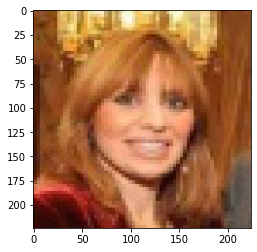

In [ ]:
model_tester(full_model=model)

This model suggests the image below is a:  N000234  with a probability of 62.82 %
____________________________________
The ground truth is:   n000234
____________________________________

The two next most likely choices are: 
            N000261 with probability 30.46 % 
            N000403 with probability 3.11 %
____________________________________


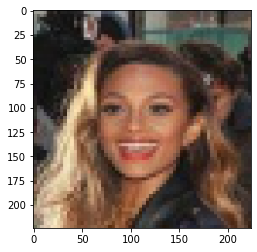

In [ ]:
model_tester(full_model=model)

In [ ]:
# save the model
model.save('/content/drive/MyDrive/ML Project/models/mobilenet.h5')